## TP Class Diabète

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uciml/pima-indians-diabetes-database")

print("Path to dataset files:", path)

c:\Users\USER\.GPUVenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\USER\.cache\kagglehub\datasets\uciml\pima-indians-diabetes-database\versions\1


In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv(r"C:\Users\USER\.cache\kagglehub\datasets\uciml\pima-indians-diabetes-database\versions\1\diabetes.csv", delimiter=',', nrows = 1000)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
# Colonnes où zéro n'est pas plausible
cols_with_zero = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

for col in cols_with_zero:
    df[col] = df[col].replace(0, df[col].median())


       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  121.656250      72.386719      27.334635   94.652344   
std       3.369578   30.438286      12.096642       9.229014  105.547598   
min       0.000000   44.000000      24.000000       7.000000   14.000000   
25%       1.000000   99.750000      64.000000      23.000000   30.500000   
50%       3.000000  117.000000      72.000000      23.000000   31.250000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    32.450911                  0.471876   33.240885    0.348958  
std      6.875366                  0.331329   11.760232    0.476951  
min     18.200000                  

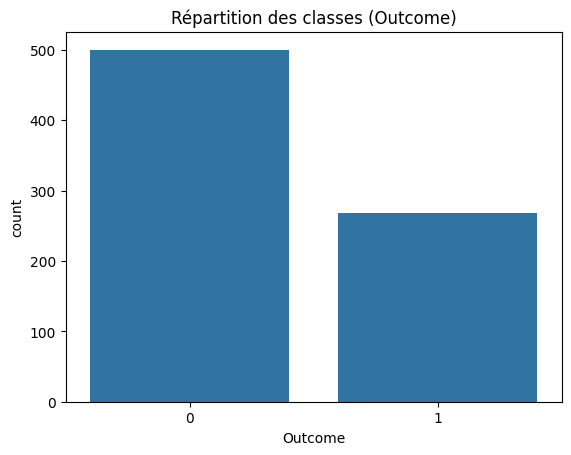

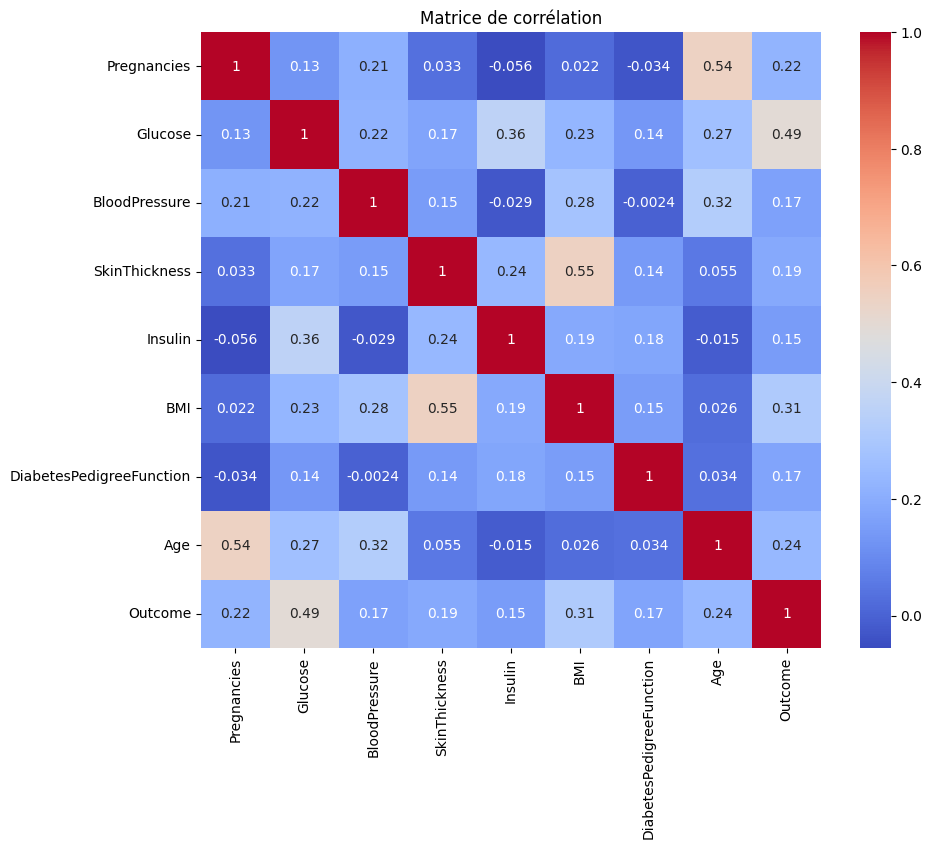

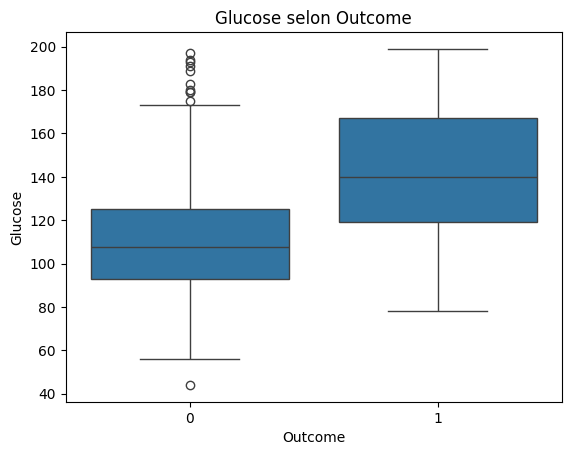

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Statistiques descriptives
print(df.describe())

# Visualiser la répartition de la variable cible
sns.countplot(x='Outcome', data=df)
plt.title('Répartition des classes (Outcome)')
plt.show()

# Visualiser la corrélation entre les variables
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Matrice de corrélation')
plt.show()

# Boxplot du glucose selon le résultat
sns.boxplot(x='Outcome', y='Glucose', data=df)
plt.title('Glucose selon Outcome')
plt.show()


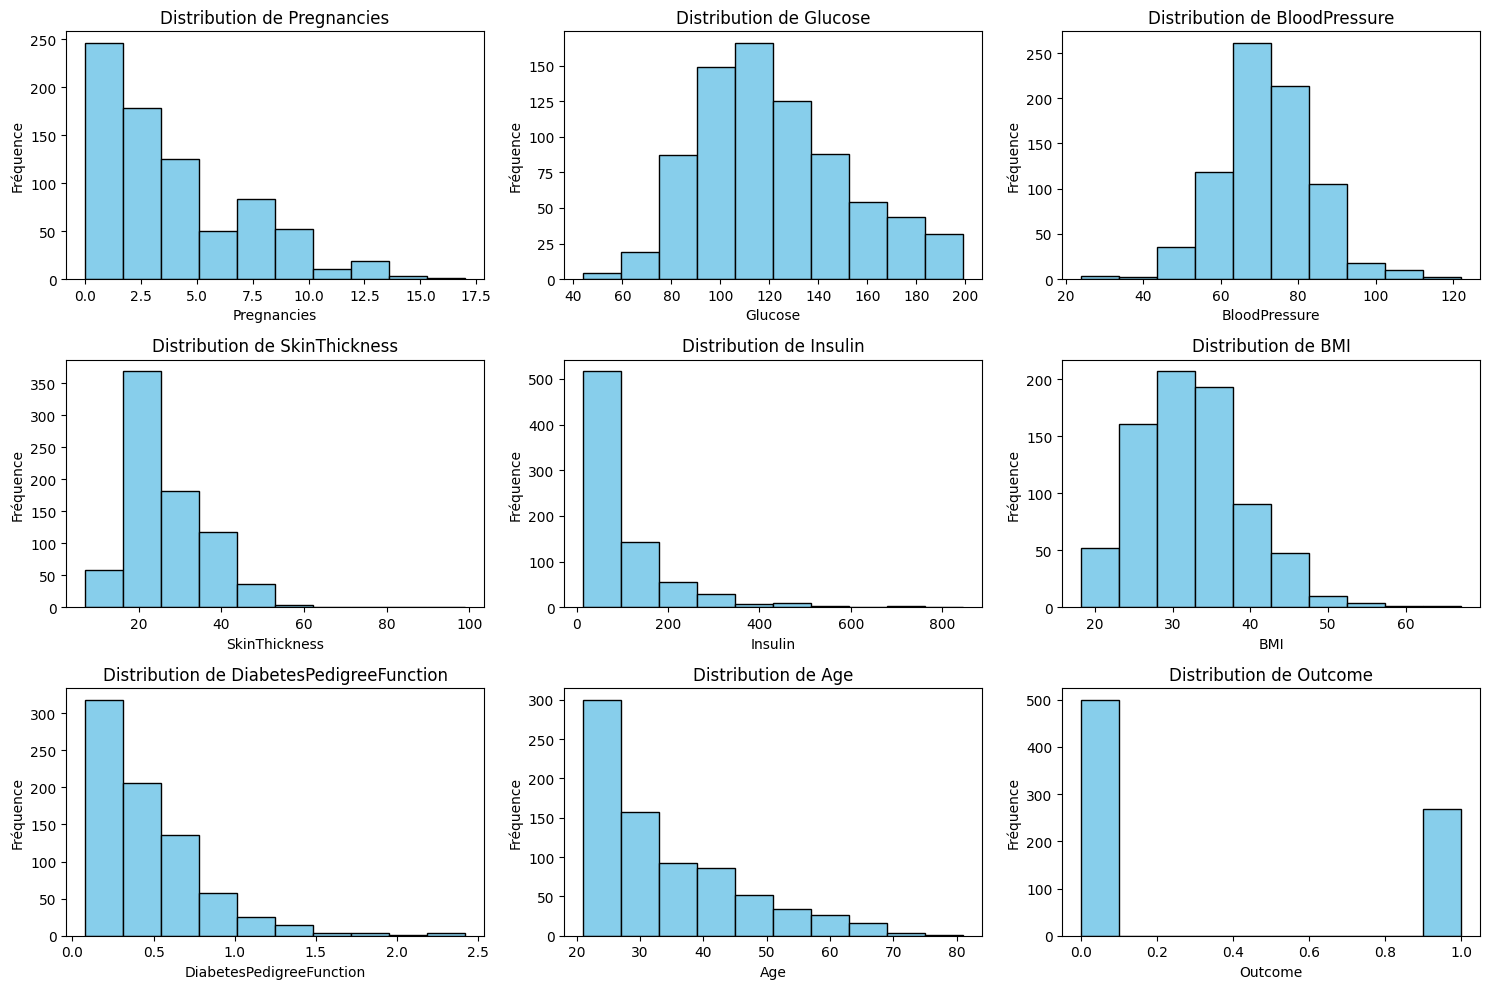

In [5]:
import matplotlib.pyplot as plt

# Toutes les colonnes à afficher
columns = df.columns

fig, ax = plt.subplots(3, 3, figsize=(15, 10))
ax = ax.flatten()  # pour pouvoir accéder facilement avec un seul index

for i, col in enumerate(columns):
    ax[i].hist(df[col], bins=10, color='skyblue', edgecolor='black')
    ax[i].set_title(f'Distribution de {col}')
    ax[i].set_xlabel(col)
    ax[i].set_ylabel('Fréquence')


plt.tight_layout()
plt.show()


### Création des modèles

#### RandomForest

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Séparer variables explicatives et cible
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Diviser en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Modèle
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)

# Prédiction
y_pred1 = rfc.predict(X_test)

# Évaluation
print("Accuracy:", accuracy_score(y_test, y_pred1))
print("\nClassification Report:\n",classification_report(y_test, y_pred1))



Accuracy: 0.7402597402597403

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.87      0.81        95
           1       0.72      0.53      0.61        59

    accuracy                           0.74       154
   macro avg       0.73      0.70      0.71       154
weighted avg       0.74      0.74      0.73       154



#### XGBoost

In [7]:
import xgboost

modelxgb = xgboost.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
modelxgb.fit(X_train, y_train)

y_pred2 = modelxgb.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred2))
print("\nClassification Report:\n", classification_report(y_test, y_pred2))

Accuracy: 0.7402597402597403

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.83      0.80        95
           1       0.69      0.59      0.64        59

    accuracy                           0.74       154
   macro avg       0.73      0.71      0.72       154
weighted avg       0.74      0.74      0.74       154



c:\Users\USER\.GPUVenv\lib\site-packages\xgboost\training.py:183: UserWarning: [08:53:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


### Utilisation de Shap

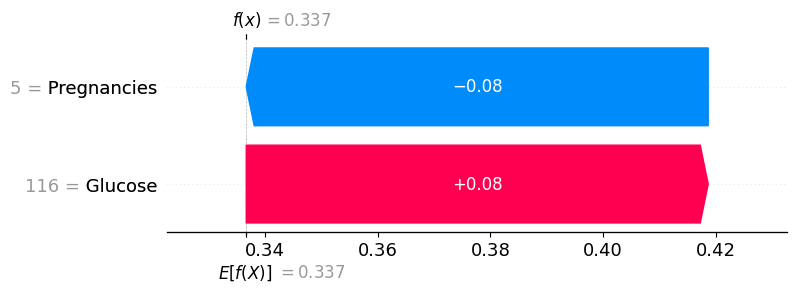

In [8]:
import shap

# 1. Créer l'explainer avec les données d'entraînement (attention, utiliser X_train ici)
explainer = shap.TreeExplainer(rfc, feature_perturbation="tree_path_dependent")

# 2. Calculer les valeurs SHAP sur le test set (ou un sous-échantillon pour rapidité)
shap_values = explainer.shap_values(X_test)

# 3. Pour classification binaire, shap_values est une liste avec 2 éléments (classe 0 et classe 1)
# On choisit la classe 1 (positive) pour l'interprétation
shap_values_class1 = shap_values[1]

# 4. Faire le beeswarm plot pour la classe 1
shap.waterfall_plot(shap.Explanation(values=shap_values_class1[0],
                                     base_values=explainer.expected_value[1],
                                     data=X_test.iloc[0]))



In [30]:
import shap

# 1. Explicateur SHAP
explainer = shap.Explainer(modelxgb, X)

# 2. Générer les explications
explanation = explainer(X)

# 3. Récupérer les valeurs SHAP
shap_values = explanation.values

# 4. Comparer la somme des SHAP values + base value au score prédit
y_pred2 = modelxgb.predict_proba(X)[:, 1]  # probabilité classe 1

# Vérification : somme des SHAPs + base value ≈ prédiction
diff = np.abs(shap_values.sum(axis=1) + explanation.base_values - y_pred2)
print("Max erreur d'approximation SHAP vs y_pred:", diff.max())

# # 5. Beeswarm plot
# shap.plots.beeswarm(explanation)

Max erreur d'approximation SHAP vs y_pred: 9.854004293878116


Premier individu du dataset : 1
Pregnancies: 6
Glucose: 148
BloodPressure: 72
SkinThickness: 35
Insulin: 30.5
BMI: 33.6
DiabetesPedigreeFunction: 0.627
Age: 50


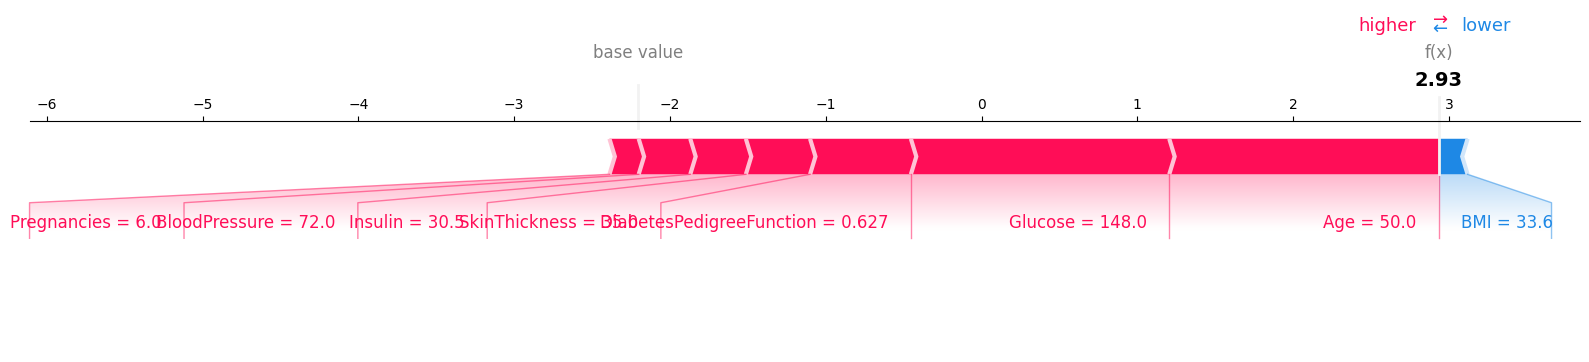

In [31]:
print("Premier individu du dataset :",y[0])
for i, col in enumerate(X.columns):
    print(f"{col}: {X.iloc[0,i]}")
shap.initjs()
shap.plots.force(explanation[0], matplotlib=True, show=True)


On remarque que pour le premier individu du dataset qui est diabétique, le glucose et l'age on représenté un impacte important dans sont diagnostic (25% des variables justifi plus de 50% du diagnostic). Ce sont donc des valeurs significatives dans notre modèle.

### Etude des variables significative (vue générale)

In [32]:
shap.plots.force(explanation)


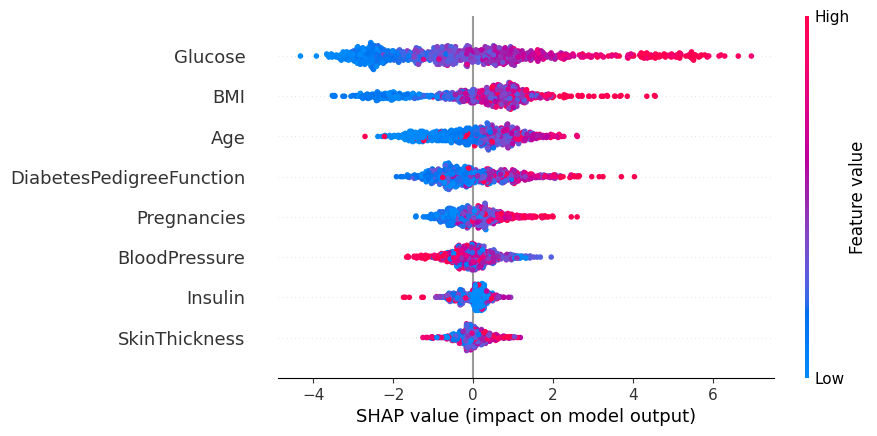

In [33]:
shap.plots.beeswarm(explanation)

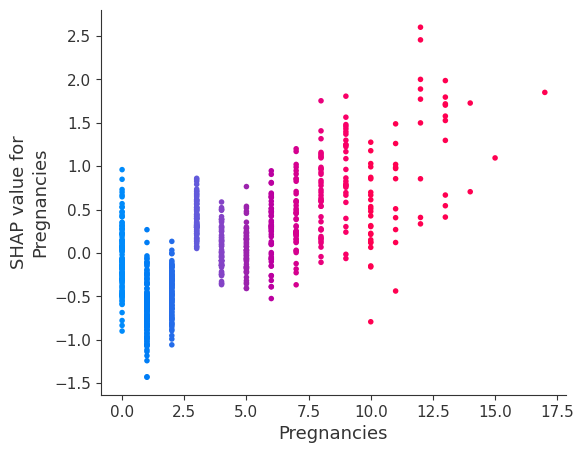

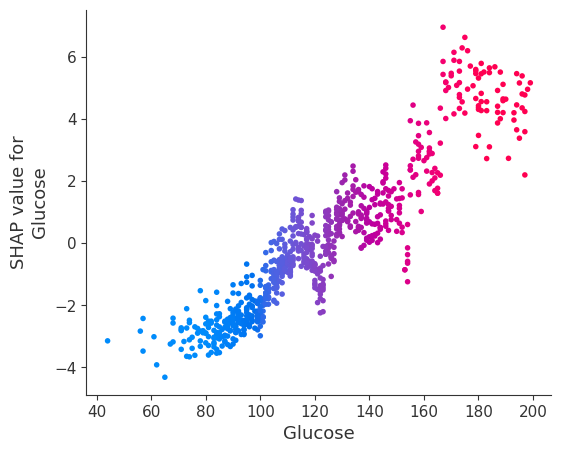

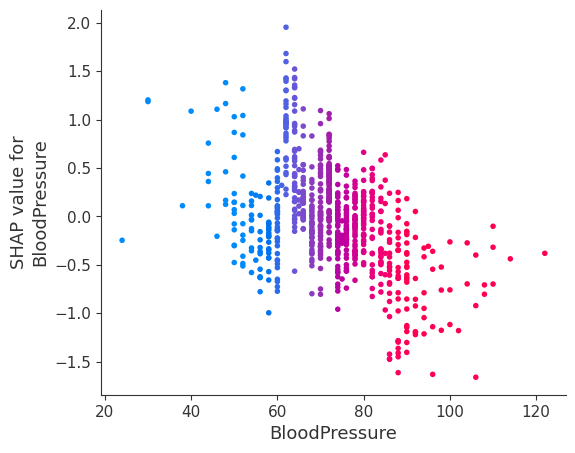

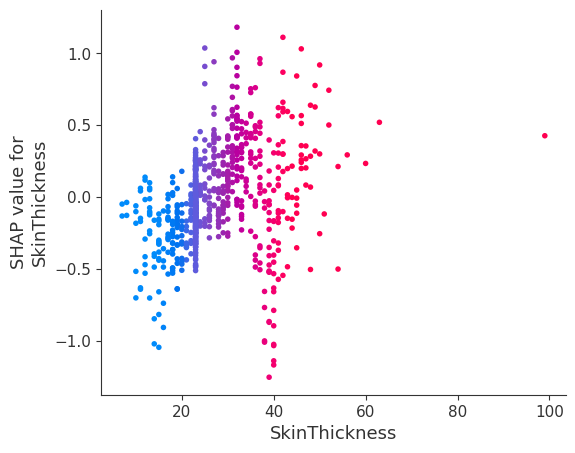

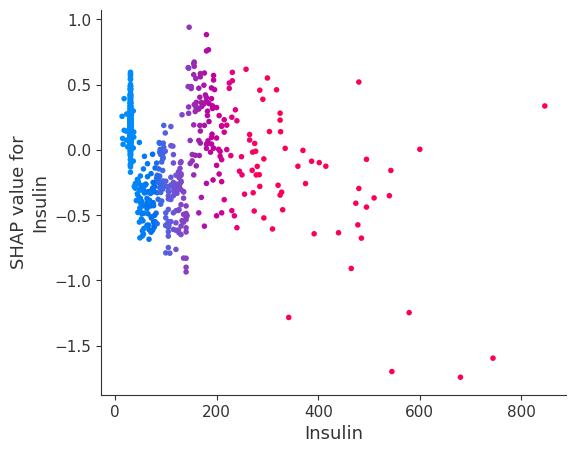

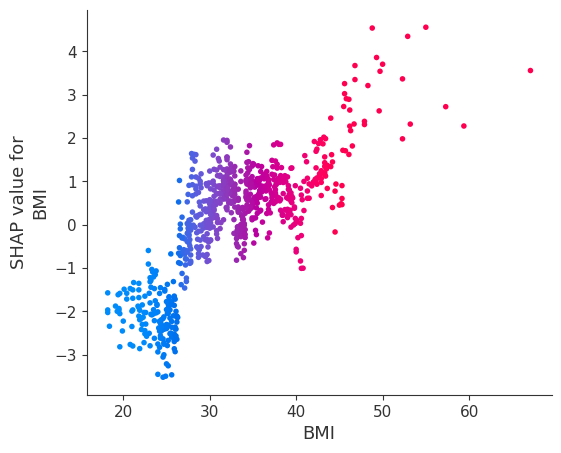

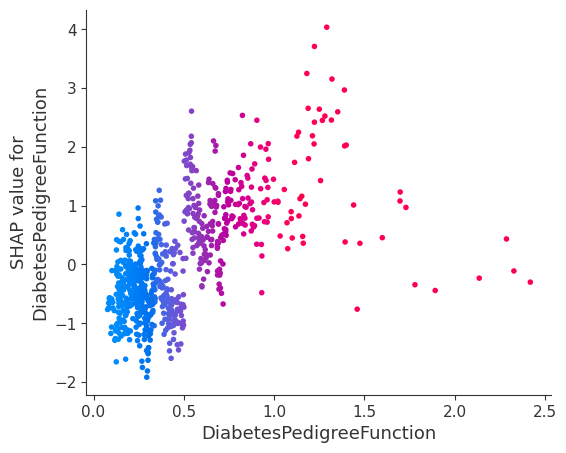

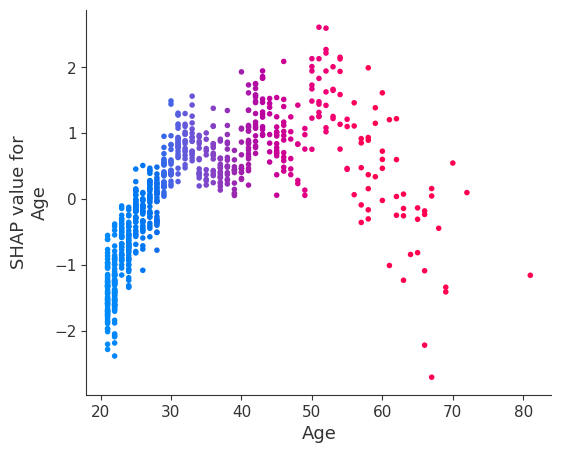

In [40]:
# fig,ax = plt.subplots(4, 2, figsize=(15, 20))
# ax = ax.flatten()

for i, col in enumerate(X.columns):
    shap.dependence_plot(col, shap_values, X, interaction_index=col)

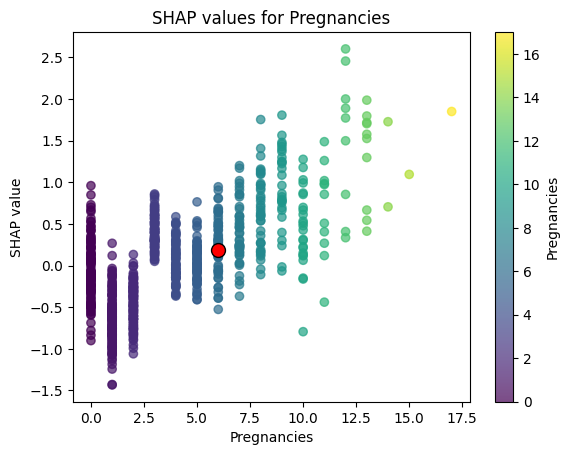

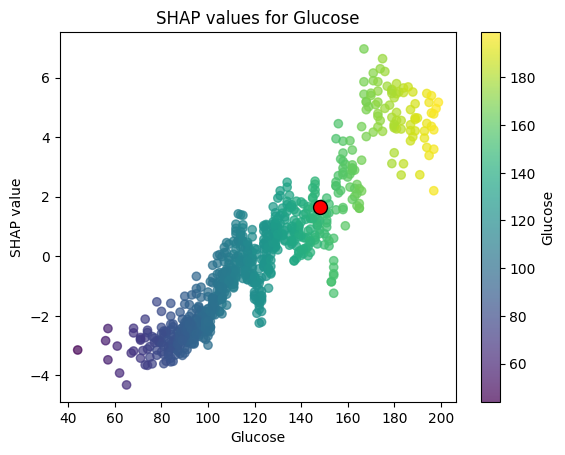

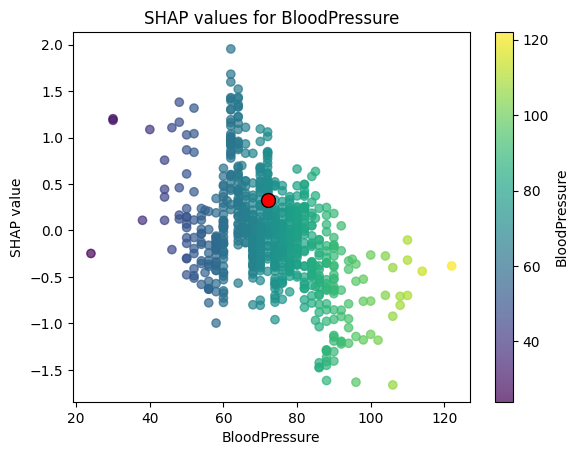

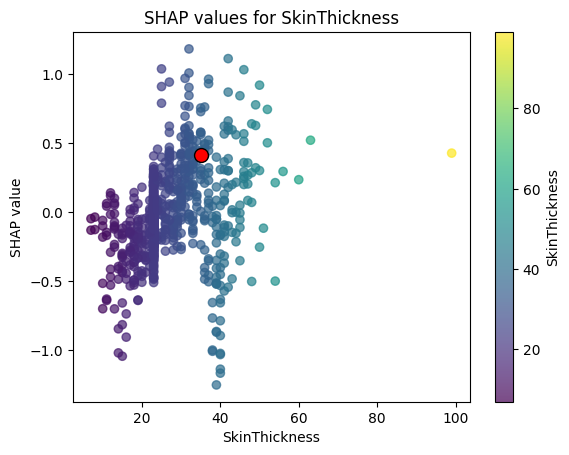

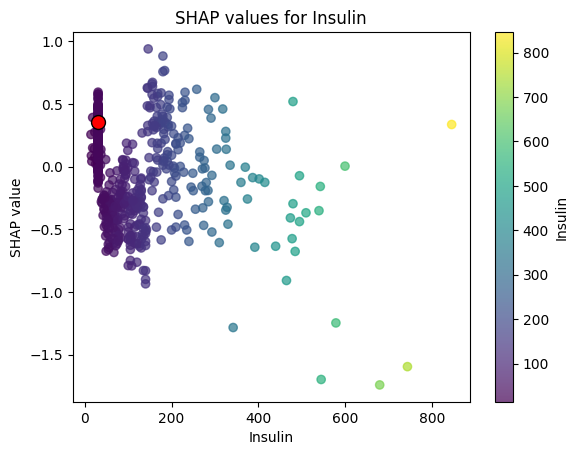

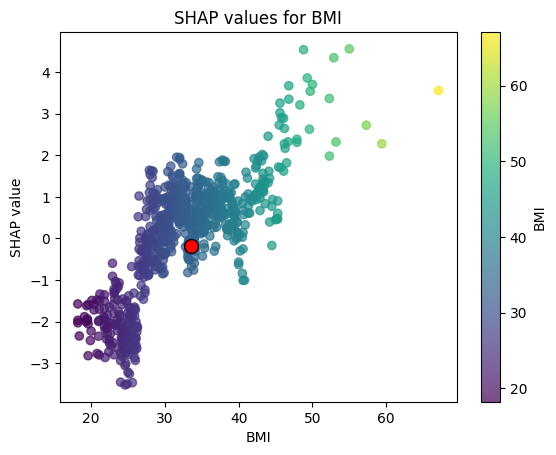

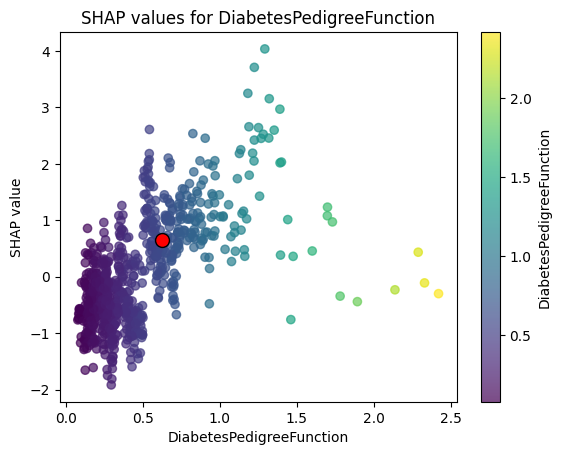

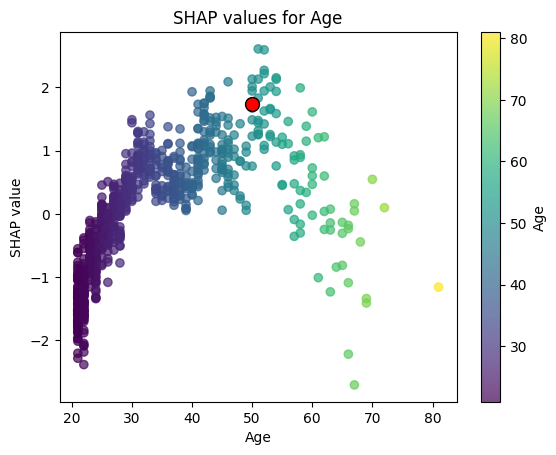

In [62]:
import matplotlib.pyplot as plt

for i, col in enumerate(X.columns):
    plt.figure()
    scatter = plt.scatter(
        X[col],                     # x-axis: feature values
        shap_values[:, i],         # y-axis: SHAP values
        c=X[col],                  # color based on feature values
        cmap="viridis",            # colormap, change to e.g., "coolwarm", "plasma" etc.
        alpha=0.7
    )
    plt.scatter(
    X.iloc[0][col],
    shap_values[0, i],
    color='red',
    edgecolor='black',
    s=100,         # taille du point
    zorder=3,      # passe au-dessus des autres points
    label="Point d'intérêt"
    )
    plt.xlabel(col)
    plt.ylabel("SHAP value")
    plt.title(f"SHAP values for {col}")
    plt.colorbar(scatter, label=col)  # colorbar labeled with feature name
    plt.show()
